# Introduction

Ben asked about resource use for pipeline files.

I've got condor log files laying around, can I read them?

In [1]:
import pandas
import re
import datetime
from pathlib import Path
from glob import glob
import os
import sys
import itertools
from pprint import pprint

In [2]:
WRS = str(Path("~/proj/woldlab-rna-seq").expanduser())
if WRS not in sys.path:
    sys.path.append(WRS)

In [15]:
from woldrnaseq.models import load_library_tables
from woldrnaseq.common import find_fastqs_by_glob

In [4]:
analysis_dir = Path("~/proj/analysis").expanduser()

In [5]:
star_log = analysis_dir / "AAAWCGHM5/24309/align-star-0.log"
rsem_log = analysis_dir / "AAAWCGHM5/24309/rsem-0.log"

In [6]:
def read_rest(instream):
    for line in instream:
        if line.startswith("..."):
            return

def parse_duration(timestamp):
    hours, minutes, seconds = timestamp.split(":")
    duration = datetime.timedelta(hours=int(hours), minutes=int(minutes), seconds=int(seconds))
    return duration.seconds

def read_termination(instream):
    parsed = {}
    line = instream.readline().rstrip()
    match = re.search(r"return value (?P<return>[\d]+)", line)
    if match is None:
        print("Unrecognized line:", line)
        return
    parsed["return_value"] = int(match["return"])

    usage_re = re.compile(r"Usr [\d] (?P<usr>[\d]{2}:[\d]{2}:[\d]{2}), Sys [\d]+ (?P<sys>[\d]{2}:[\d]{2}:[\d]{2})  -  (?P<usage>(Run|Total) (Remote|Local) Usage)")
    for i in range(4):
        line = instream.readline().rstrip()
        match = usage_re.search(line)
        if match is None:
            print("Unable to recognize usage:", line)
            return
        user = parse_duration(match["usr"])
        system = parse_duration(match["sys"])
        parsed[match["usage"]] = user + system
    for i in range(4):
        line = instream.readline()
    # Partitionaable resources
    instream.readline()
    fields = instream.readline().rstrip().split()
    #parsed["cpu"] = {"request": int(fields[2]), "allocated": int(fields[3])}
    parsed["cpu"] = int(fields[3])
    KB = 2 ** 10
    MB = 2 ** 20
    fields = instream.readline().rstrip().split()
    #parsed["disk"] = {"usage": int(fields[3]) * KB, "request": int(fields[4]) * KB, "allocated": int(fields[5]) * KB}
    parsed["disk"] = int(fields[3]) * KB
    fields = instream.readline().rstrip().split()
    #parsed["memory"] = {"usage": int(fields[3]) * MB, "request": int(fields[4]) * MB, "allocated": int(fields[5]) * MB}
    parsed["memory"] = int(fields[3]) * MB
    end = instream.readline().rstrip()
    assert end == "..."
    return parsed

def parse_condor_log(instream):
    header = re.compile(r"[\d]+ \([\d.]+\) (?P<date>[\d]{2}/[\d]{2}) (?P<time>[\d]{2}:[\d]{2}:[\d]{2}) (?P<status>[^:]+)(: (?P<args>.*)|(.))")
    usage = None
    for line in instream:
        line = line.rstrip()
        match = header.search(line)
        if match is None:
            print("Unrecognized line:", line)
            continue

        status = match.group("status")
        #print(status)
        if status == "Job terminated":
            usage = read_termination(instream)
        else:
            read_rest(instream)
    return usage

with open(star_log, "rt") as instream:
    pprint(parse_condor_log(instream))

with open(rsem_log, "rt") as instream:
    pprint(parse_condor_log(instream))
    
    

{'Run Local Usage': 0,
 'Run Remote Usage': 2002,
 'Total Local Usage': 0,
 'Total Remote Usage': 2002,
 'cpu': 8,
 'disk': 2304000,
 'memory': 13387169792,
 'return_value': 0}
{'Run Local Usage': 0,
 'Run Remote Usage': 25136,
 'Total Local Usage': 0,
 'Total Remote Usage': 25136,
 'cpu': 8,
 'disk': 48979726336,
 'memory': 31989956608,
 'return_value': 0}


In [28]:

def compute_star_usage(libraries):
    star_usage = {}
    for library_id, row in libraries.iterrows():
        curdir = os.getcwd()
        fastq_size = 0        
        analysis_dir = Path(row.analysis_dir)
        analysis_root = analysis_dir.parent
        os.chdir(analysis_root)
        for fastq in find_fastqs_by_glob(row.read_1):
            fastq_size += Path(fastq).stat().st_size
        if "read_2" in libraries.columns:
            for fastq in find_fastqs_by_glob(row.read_2):
                fastq_size += Path(fastq).stat().st_size
        os.chdir(curdir)
        if fastq_size < 2 ** 20:
            print("Skipping {}, fastqs archived".format(library_id))
            continue

        with open(analysis_dir / "align-star-0.log", "rt") as instream:
            star_usage.setdefault(library_id, {}).update(parse_condor_log(instream))
            star_usage[library_id]["fastq_size"] = fastq_size
    return star_usage

#libraries = load_library_tables([analysis_dir / "AAAWCGHM5/libraries.tsv"])
#compute_star_usage(libraries)

In [31]:
library_files = [
    analysis_dir / "AAAWCFLM5/libraries.tsv",
    analysis_dir / "AAAWCFNM5/libraries.tsv",
    analysis_dir / "AAAWCGFM5/libraries.tsv",
    analysis_dir / "AAAWCGHM5/libraries.tsv",
    analysis_dir / "AAAWCGKM5/libraries.tsv",
    analysis_dir / "AAAWCH3M5/libraries.tsv",
    analysis_dir / "AAAWCHCM5/libraries.tsv",
    analysis_dir / "AAAWCHHM5/libraries.tsv",
    analysis_dir / "AAAWCHLM5/libraries.tsv",
    analysis_dir / "AAAWCJLM5/libraries.tsv",
    analysis_dir / "AAAWCY3M5/libraries.tsv",
    analysis_dir / "AAAWHLVM5/libraries.tsv",
    analysis_dir / "AAAWHMGM5/libraries.tsv",
    #analysis_dir / "AAC3YMLM5/libraries.tsv", #this one got mostly reran on AAC53NJM5
    analysis_dir / "AAC53NJM5/libraries.tsv",
    #"/woldlab/loxcyc/home/diane/proj/encode3-rna-evaluation/library.tsv",
]

libraries = load_library_tables(library_files)

star_usage = compute_star_usage(libraries)

Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCFNM5/24523/24523_S1_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCFNM5/24524/24524_S2_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCFNM5/24525/24525_S3_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCFNM5/24526/24526_S4_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCFNM5/24527/24527_S5_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCFNM5/24528/24528_S6_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCFNM5/24529/24529_S7_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCFNM5/24530/24530_S8_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCFNM5/24531/24531_S9_R1_001.fastq.gz. skipping
Can't find

Skipping 24523, fastqs archived
Skipping 24524, fastqs archived
Skipping 24525, fastqs archived
Skipping 24526, fastqs archived
Skipping 24527, fastqs archived
Skipping 24528, fastqs archived
Skipping 24529, fastqs archived
Skipping 24530, fastqs archived
Skipping 24531, fastqs archived
Skipping 24532, fastqs archived
Skipping 24533, fastqs archived
Skipping 24534, fastqs archived
Skipping 24511, fastqs archived
Skipping 24512, fastqs archived
Skipping 24513, fastqs archived
Skipping 24514, fastqs archived
Skipping 24515, fastqs archived
Skipping 24516, fastqs archived
Skipping 24517, fastqs archived
Skipping 24518, fastqs archived
Skipping 24519, fastqs archived
Skipping 24520, fastqs archived
Skipping 24521, fastqs archived
Skipping 24522, fastqs archived
Skipping 24388_E1208017_BS171_ENC4_cDNA725, fastqs archived
Skipping 24389_E1311604_BS172_ENC4_cDNA726, fastqs archived
Skipping 24390_E1329219_BS173_ENC4_cDNA727, fastqs archived
Skipping 24391_E1652886_BS174_ENC4_cDNA728, fastqs a

Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCY3M5/24400/24400_S1_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCY3M5/24401/24401_S2_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCY3M5/24402/24402_S3_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCY3M5/24403/24403_S4_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCY3M5/24404/24404_S5_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCY3M5/24405/24405_S6_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCY3M5/24406/24406_S7_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCY3M5/24407/24407_S8_R1_001.fastq.gz. skipping
Can't find fastq /woldlab/loxcyc/home/diane/proj/flowcells/AAAWCY3M5/24408/24408_S9_R1_001.fastq.gz. skipping
Can't find

Skipping 24400_E7431498_BS183_ENC4_cDNA737, fastqs archived
Skipping 24401_E8583444_BS184_ENC4_cDNA738, fastqs archived
Skipping 24402_E8895621_BS185_ENC4_cDNA739, fastqs archived
Skipping 24403_E8947111_BS186_ENC4_cDNA740, fastqs archived
Skipping 24404_E8949399_BS187_ENC4_cDNA741, fastqs archived
Skipping 24405_E8969200_BS188_ENC4_cDNA742, fastqs archived
Skipping 24406_E8973904_BS189_ENC4_cDNA743, fastqs archived
Skipping 24407_E9620322_BS190_ENC4_cDNA744, fastqs archived
Skipping 24408_E9696602_BS191_ENC4_cDNA745, fastqs archived
Skipping 24409_E9835349_BS192_ENC4_cDNA746, fastqs archived
Skipping 24410_E9876975_BS193_ENC4_cDNA747, fastqs archived
Skipping 24411_E9972216_BS194_ENC4_cDNA748, fastqs archived
Skipping 24412_E2728434_BS149_ENC4_cDNA749, fastqs archived
Skipping 24208_E3348003_BS123_ENC4_cDNA685, fastqs archived
Skipping 24209_E5605087_BS124_ENC4_cDNA686, fastqs archived
Skipping 24210_E7461192_BS125_ENC4_cDNA687, fastqs archived
Skipping 24211_E7469794_BS126_ENC4_cDNA6

In [34]:
star = pandas.DataFrame(star_usage).T
star.shape

(90, 9)

<AxesSubplot:xlabel='fastq_size', ylabel='memory'>

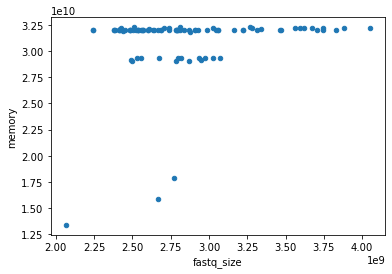

In [33]:
star.plot.scatter(x="fastq_size", y="memory")

<AxesSubplot:xlabel='fastq_size', ylabel='disk'>

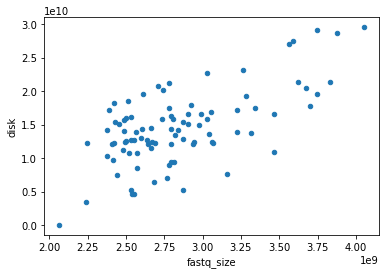

In [35]:
star.plot.scatter(x="fastq_size", y="disk")